# Information Theory visualized: Decision trees

Illustrates when greedy decision tree learning can go wrong

First version: 10/28/2024
This version: 11/12/2024
https://northeastern-datalab.github.io/cs7840/fa24/calendar.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.colors import ListedColormap, to_rgb

filetype="png"

## 1. Create a grid of 100x100 points for A and B features

In [2]:
a_values = np.linspace(0, 1, 10)
b_values = np.linspace(0, 1, 10)
a, b = np.meshgrid(a_values, b_values)
a = a.flatten()
b = b.flatten()

CASE = 2
if CASE == 1:
    # Apply XOR function for classification
    classification = np.where((a < 0.5) & (b > 0.5) | (a > 0.5) & (b < 0.5), 1, 0)
elif CASE == 2:
    # create example from slides
    classification = np.where((a < 0.5) & (b > 0.4) | (a > 0.5) & (b < 0.6), 1, 0)

# Create the DataFrame
df = pd.DataFrame({'A': a, 'B': b, 'Class': classification})
print(df)

           A    B  Class
0   0.000000  0.0      0
1   0.111111  0.0      0
2   0.222222  0.0      0
3   0.333333  0.0      0
4   0.444444  0.0      0
..       ...  ...    ...
95  0.555556  1.0      0
96  0.666667  1.0      0
97  0.777778  1.0      0
98  0.888889  1.0      0
99  1.000000  1.0      0

[100 rows x 3 columns]


## 2. Visualize the data points

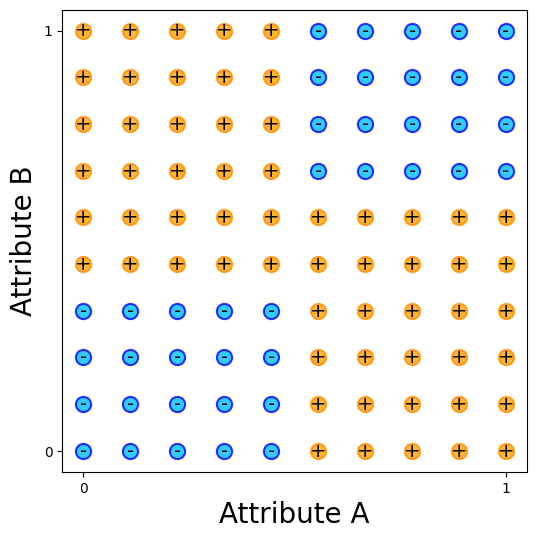

In [3]:
plt.figure(figsize=(6, 6))

# Define colors for classes
bright_colors = {0: 'deepskyblue', 1: 'orange'}
edge_colors = {0: 'blue', 1: 'darkorange'}

# Plot with circles and specified colors, and dark circumference
for class_value in [0, 1]:
    subset = df[df['Class'] == class_value]
    plt.scatter(
        subset['A'], subset['B'],
        s=120,
        color=bright_colors[class_value],
        edgecolor=edge_colors[class_value],
        linewidth=1.5,
        marker='o',
        alpha=0.8
    )

# Adding "+" and "-" labels for each data point based on classification
for i, row in df.iterrows():
    label = "+" if row['Class'] == 1 else "-"
    plt.text(row['A'], row['B'], label, ha='center', va='center', fontsize=14, color='black')

# Setting axis labels with only 0 and 1 shown
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.xlabel('Attribute A', fontsize=20)
plt.ylabel('Attribute B', fontsize=20)

# Save the plot as a PDF
filename = "Fig_202_decision_tree_dataframe"
plt.savefig("figures/" + filename + "." + filetype,
            format=filetype,
            dpi=None,
            edgecolor='w',
            orientation='portrait',
            transparent=False,
            bbox_inches='tight',
            pad_inches=0.05)
plt.show()

## 3. Learn a decision tree

In [4]:
# Extract features and target from DataFrame
X = df[['A', 'B']]
y = df['Class']

# Create and fit a Decision Tree Classifier with information gain (entropy) criterion
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

## 4. Plotting the decision tree

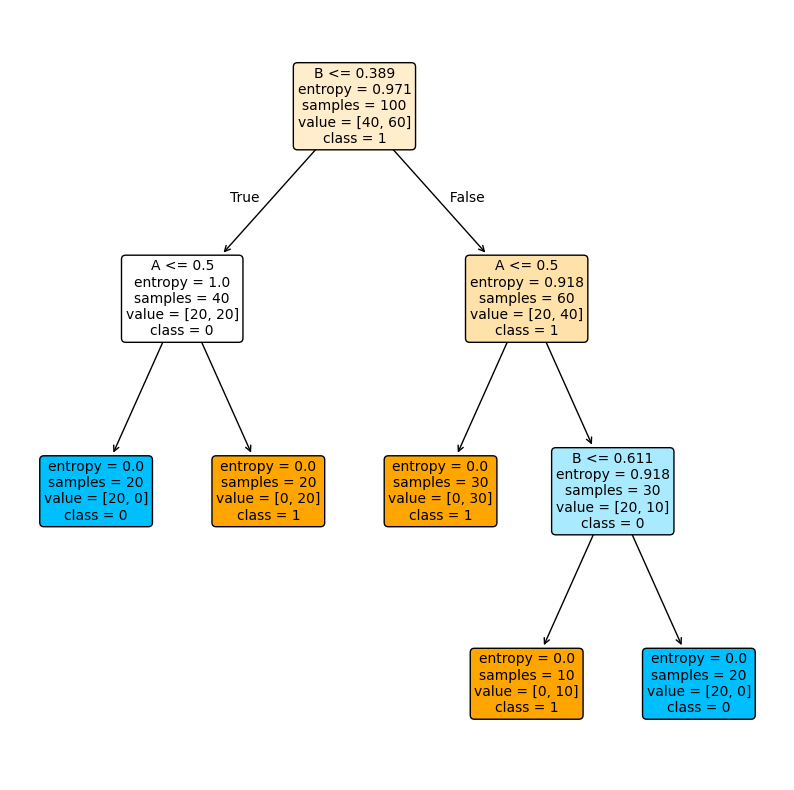

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
tree_plot = plot_tree(
    clf,
    feature_names=['A', 'B'],
    class_names=['0', '1'],
    filled=True,
    # proportion=True,
    fontsize=10,
    rounded=True,
    impurity=True,
    # max_depth=2,    # does not work either
)

# (11/2024): a necessary preprocessing step required to make this solution work (+ another change)
# https://stackoverflow.com/questions/70437840/how-to-change-colors-for-decision-tree-plot-using-sklearn-plot-tree
# 1. As preprocessing setp, first remove all the empty nodes from tree_plot.
#    Otherwise, the number of entries in 'tree_plot' and in 'clf.tree_.value' are not the same
# 2. Replacing the impurity measure with a simple linear measure
tree_array = []
for node in tree_plot:
    if node.get_bbox_patch() is not None:       # some nodes that don't have a bbox_patch
        tree_array.append(node)

colors = ['deepskyblue', 'orange']

for node, impurity, value in zip(tree_array, clf.tree_.impurity, clf.tree_.value):
    # let the max value decide the color; whiten the color depending on impurity
    bbox_patch = node.get_bbox_patch()
    r, g, b = to_rgb(colors[np.argmax(value)])      # color of winning class

    # OPTION 1: impurity turns out to not be a great visual measure as it shows strong colors only close to perfect separation
    f = impurity

    # OPTION 2: a continuous fraction works better
    max_value = np.max(value)
    sum_value = np.sum(value)
    proportion = max_value / sum_value
    f = 2 * (1-proportion)       # for N colors: f = N * (1-max_value)

    node.get_bbox_patch().set_facecolor((f + (1 - f) * r, f + (1 - f) * g, f + (1 - f) * b))
    node.get_bbox_patch().set_edgecolor('black')


filename = "Fig_202_decision_tree_learned"
plt.savefig("figures/" + filename + "." + filetype,
            format=filetype,
            dpi=None,
            edgecolor='w',
            orientation='portrait',
            transparent=False,
            bbox_inches='tight',
            pad_inches=0.05)
plt.show()